# Introdução

A função de Rastrigin apresenta um desafio interessante para algoritmos de otimização, pois possui muitos mínimos locais e um mínimo global em (0, 0), sendo uma função multimodal e não convexa. A função de Rastrigin é definida por:

\begin{equation}
f(x) = An + \sum_{i=1}^{n} \left[ x_i^2 - A \cos(2\pi x_i) \right]
\end{equation}

Neste trabalho será implementado um algoritmo de enxame de partículas para otimizar a função de Rastrigin, utilizando o Global Best PSO com o algoritmo canônico e uma variação utilizando o operador de contrição $\chi$.

In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series
from benchmark_functions import Rastrigin

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Função Objetivo

A função objetivo aqui utilizada possui um domíni estabelecido para o problema de otimização, onde $x_i \in [-5.12, 5.12]$ para todo $i$.

Para representações reais do problema, tal qual o algoritmo de evolução diferencial, é necessário utilizar uma função de penalição para valores fora do domínio. A função de penalição utilizada é a de restrição quadrática, que penaliza valores fora do domínio com um valor proporcional ao quadrado da diferença.

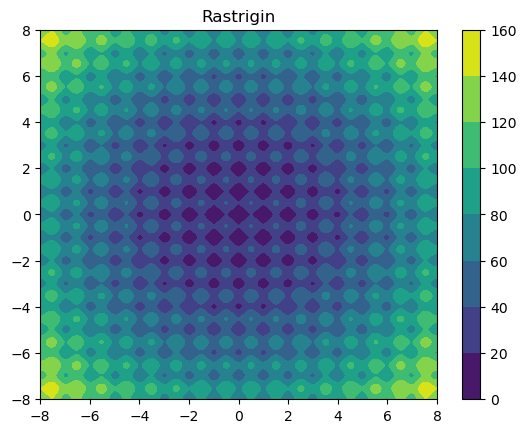

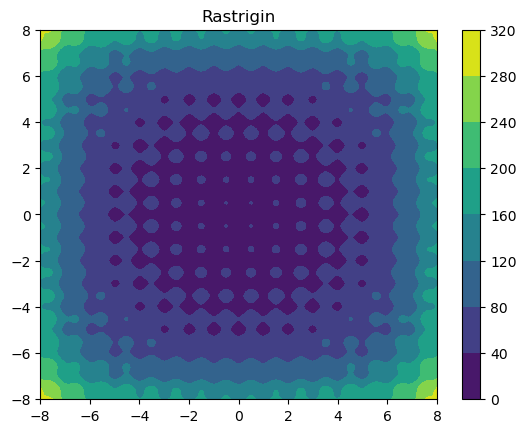

In [2]:
rastringin = Rastrigin(2)

points = np.linspace(-8, 8, 1000)

values = [rastringin([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

def rastringin_constrained_generator(rastringin):
    # Método utilizado: Penalização com parâmetro de penalização = 1000
    # Função de penalização 1: p * max(0, (x - 5.12))²
    # Função de penalização 2: p * max(0, (-x - 5.12))²
    # Obs: Por não ser realmente um problema de otimização convexa, iremos deixar o p fixado em 10, o que
    # não é um problema por sabermos que os mínimos locais são maiores que o global.
    p = 10
    def wrapper(x):
        return rastringin(x) + p * sum([max(0, (x_i - 5.12))**2 for x_i in x]) + p * sum([max(0, (-x_i - 5.12))**2 for x_i in x])
    
    return wrapper

rastringin_constrained = rastringin_constrained_generator(rastringin)

values = [rastringin_constrained([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

# Função em N=10

A função utilizada no problema real possui 10 dimensões, ou seja, $n=10$.

In [3]:
rastringin = Rastrigin(10)

rastringin_constrained = rastringin_constrained_generator(rastringin)

# Criação da População

Para iniciar a **população**, será utilizada uma amostragem aleatória uniforme no domínio da função. O tamanho da população será de 100 indivíduos.

E, relação à velocidade de cada partícula, todos indivíduos iniciarão com valores nulos em cada um dos eixos.

Para conseguir armazenar todas estas informações, além da melhor posição individual e global, será criada uma classe chamada `Particle`, cujo método update será responsável por atualizar a posição e a velocidade de cada partícula.

> Neste código podemos notar que a melhor posição é a global_best_position, isto se deve ao fato de estarmos implementando o Global Best PSO, onde a melhor posição global é a que é utilizada para atualizar a velocidade de cada partícula. Possíveis testes de melhoria do algoritmo poderiam ser feitos utilizando o Local Best PSO.

In [4]:
class Particle:
    def __init__(self, position, velocity, velocity_function):
        self.position = position
        self.velocity = velocity
        self.best_position = position
        self.best_value = rastringin_constrained(position)
        self.velocity_function = velocity_function # Função de atualização de velocidade, será implementada posteriormente
        self.updates = 0

    def update(self, w, c1, c2, global_best_position):
        self.velocity = self.velocity_function(self.position, self.velocity, w, c1, c2, self.best_position, global_best_position)
        self.position = self.position + self.velocity
        value = rastringin_constrained(self.position)
        if value < self.best_value:
            self.best_value = value
            self.best_position = self.position
        self.updates += 1

    @property
    def value(self):
        return rastringin_constrained(self.position)

def init_population(_mu:int = 1000, n:int = 10, velocity_update_func=None) -> list[Particle]:
    population = []
    for i in range (_mu):
        position = np.array([rd.uniform(-5.12, 5.12) for _ in range(n)])
        velocity = np.zeros(n)
        population.append(Particle(position, velocity, velocity_update_func))
    return population

# Velocidade

A velocidade de cada partícula é atualizada de acordo com a seguinte equação:

\begin{equation}
v_{i+1} = w \cdot v_i + c_1 \cdot r_1 \cdot (pbest_i - x_i) + c_2 \cdot r_2 \cdot (gbest - x_i)
\end{equation}

Onde:
- $v_{i+1}$ é a velocidade da partícula na próxima iteração
- $w$ é o fator de inércia
- $v_i$ é a velocidade da partícula na iteração atual
- $c_1$ e $c_2$ são constantes de aceleração
- $r_1$ e $r_2$ são valores aleatórios entre 0 e 1
- $pbest_i$ é a melhor posição da partícula até o momento
- $gbest$ é a melhor posição global

# Posição

A posição de cada partícula é atualizada de acordo com a seguinte equação:

\begin{equation}
x_{i+1} = x_i + v_{i+1}
\end{equation}

Onde:
- $x_{i+1}$ é a posição da partícula na próxima iteração
- $x_i$ é a posição da partícula na iteração atual

In [5]:
def velocity_update(x, v, w, c1, c2, best_position, global_best_position, *args, **kwargs):
    return w*v + c1*rd.random()*(best_position - x) + c2*rd.random()*(global_best_position - x)

# Velocidade - Alternativa

Uma alternativa para a atualização da velocidade é a utilização de um coeficiente de contrição, que é uma função da constante de aceleração. A equação de atualização da velocidade é dada por:

\begin{equation}
v_{i+1} = \chi \left[ v_i + c_1 \cdot r_1 \cdot (pbest_i - x_i) + c_2 \cdot r_2 \cdot (gbest - x_i) \right]
\end{equation}

Onde $\chi$ é o coeficiente de contrição, que é dado por:

\begin{equation}
\chi = \frac{2 \cdot k}{|2 - \phi - \sqrt{\phi \cdot (\phi - 4)}|}
\end{equation}

E $\phi = c_1 \cdot r_1 + c_2 \cdot r_2$ representa a razão de aceleração.

Esta alternativa permite uma convergência mais rápida do algoritmo, uma vez que a velocidade é limitada por um fator de contrição. Além disto, neste algoritmo, podemos alterar o valor de $k$ entre 1 e 0 para diminuirmos iterativamente a exploração global e iniciarmos a exploração local. Este é exatamente o comportamento que desejamos para o algoritmo de otimização aqui implementado.


In [6]:
def velocity_update_constriction(x, v, w, c1, c2, best_position, global_best_position, *args, **kwargs):
    phi = c1 + c2
    assert phi >= 4 # Para evitar raízes negativas
    chi = 2 / abs(2 - phi - np.sqrt(phi * (phi-4)))
    v = chi * (w*v + c1*rd.random()*(best_position - x) + c2*rd.random()*(global_best_position - x))
    return v

In [7]:
def find_best_solution(max_gens:int = 10, velocity_update_func = velocity_update, w=0.9, c1=3, c2=5):
    pop = init_population(velocity_update_func=velocity_update_func)

    fitness_pop_vectors = []

    for gen in range(max_gens):
        global_best = min(pop, key=lambda x: x.value).position
        global_best_value = rastringin_constrained(global_best)
        for particle in pop:
            particle.update(w, c1, c2, global_best)
            if particle.best_value < global_best_value:
                global_best = particle.best_position
                global_best_value = particle.best_value
        fitness_pop_vectors.append(global_best_value)

    return global_best, global_best_value, fitness_pop_vectors

# Grid Search

Durante teste iniciais, foi possível observar que várias combinações, mesmo que com pequenas mudanças nos parâmetros, ocasionavam em resultados muito diferentes. Por isso, foi decidido realizar um grid search para encontrar os melhores parâmetros para o algoritmo.

In [8]:
from sklearn.model_selection import ParameterGrid

parameters = {
    "w": [0.5, 0.6, 0.7, 0.8, 0.9],
    "c1": [0, 1, 3, 5, 7, 9],
    "c2": [0, 1, 3, 5, 7, 9],
    "velocity_update_func": [velocity_update, velocity_update_constriction]
}

grid = ParameterGrid(parameters)

filtered_grid = [params for params in grid if params['c1'] + params['c2'] >= 4]

best_value_grid_search = float('inf')
best_params = None

for params in filtered_grid:
    _, global_best_value, fitness_pop_vectors = find_best_solution(max_gens=100, velocity_update_func=params['velocity_update_func'], w=params['w'], c1=params['c1'], c2=params['c2'])

    if global_best_value < best_value_grid_search:
        best_value_grid_search = global_best_value
        best_params = params

# Melhores Parâmetros

Os melhores parâmetros encontrados para o algoritmo foram:
- $w = 0.9$
- $c_1 = 9$
- $c_2 = 9$
- Função de Velocidade: Com Coeficiente de Contrição

Os resultados podem ser observados na seção de resultados.

# Resultados

Foi notado a forte influência dos parâmetros na convergência do algoritmo. A utilização do coeficiente de contrição permitiu uma convergência mais rápida do algoritmo, além de permitir a exploração local do espaço de busca.

Muitas combinações de parâmetros apresentaram melhorias pouco significativas, sendo que outras nem sequer conseguiram melhorar a solução. Isto mostra a importância de parâmetros bem ajustados para o algoritmo de otimização por enxame de partículas.

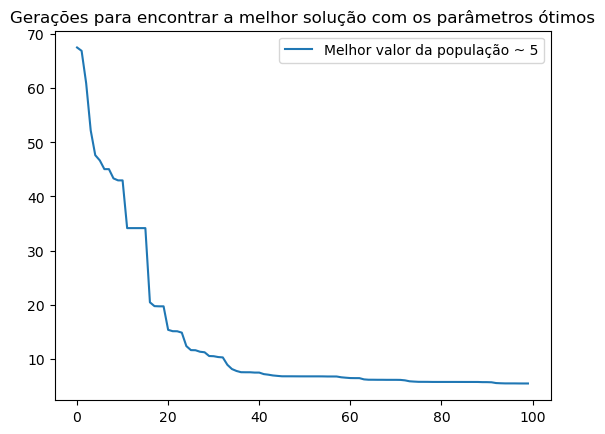

In [13]:
_, global_best_value, fitness_pop_vectors = find_best_solution(max_gens=100, velocity_update_func=best_params['velocity_update_func'], w=best_params['w'], c1=best_params['c1'], c2=best_params['c2'])

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução com os parâmetros ótimos")
plt.legend(["Melhor valor da população ~ " + str(global_best_value).split(".")[0]])
plt.show()